## **0. Import libraries**

In [1]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

## **1. Prepare dataset**


In [3]:
batch_size = 512

train_dataset = FashionMNIST('./data',
                            train = True ,
                            download = True ,
                            transform = transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                            train = False ,
                            download = True ,
                            transform = transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.35MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.83MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**

In [4]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x

class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [5]:
# Khởi tạo các mô hình
first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

## **3. Training**

In [6]:
# Define the training function

def train_model(model, optimizer, epochs, train_loader, val_loader):
    train_loss_lst = []
    train_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        count = 0

        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
            count += len(y_train)

        train_loss /= len(train_loader)
        train_loss_lst.append(train_loss)
        train_acc /= count
        train_acc_lst.append(train_acc)

        val_loss = 0.0
        val_acc = 0.0
        count = 0
        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
                count += len(y_val)

        val_loss /= len(test_loader)
        val_loss_lst.append(val_loss)
        val_acc /= count
        val_acc_lst.append(val_acc)

        print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

    return train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst

In [7]:
# Training
lr = 1e-2
criterion = nn.CrossEntropyLoss()
epochs = 100

In [8]:
# Step 1: Train with first layer
print("\nTraining first layer")

model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
metrics_1 = train_model(model, optimizer, epochs, train_loader, val_loader)

# Step 2: Train first two layers (fixed first layer)
print("\nAdd second layer")

for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

metrics_2 = train_model(model, optimizer, epochs, train_loader, val_loader)

# Step 3: Update whole progress
print("\nUpdate whole progress (layer 1, layer 2)")

for param in first.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

metrics_3 = train_model(model, optimizer, epochs, train_loader, val_loader)

# Step 4: Add the third layer
print("\nAdd the third layer")

for param in first.parameters():
    param.requires_grad = False

for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

metrics_4 = train_model(model, optimizer, epochs, train_loader, val_loader)

# Step 5: Update whole progress
for param in first.parameters():
    param.requires_grad = True

for param in second.parameters():
    param.requires_grad = True


model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

metrics_5 = train_model(model, optimizer, epochs, train_loader, val_loader)

# Step 6: Add the fourth layer
print("\nAdd the fourth layer")

for param in first.parameters():
    param.requires_grad = False

for param in second.parameters():
    param.requires_grad = False

for param in third.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

metrics_6 = train_model(model, optimizer, epochs, train_loader, val_loader)

# Step 7: Update whole progress
for param in first.parameters():
    param.requires_grad = True

for param in second.parameters():
    param.requires_grad = True

for param in third.parameters():
    param.requires_grad = True


model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

metrics_7 = train_model(model, optimizer, epochs, train_loader, val_loader)


Training first layer
EPOCH 1/100, Train_Loss: 2.3077, Train_Acc: 0.1206, Validation Loss: 1.3809, Val_Acc: 0.1167
EPOCH 2/100, Train_Loss: 2.3001, Train_Acc: 0.1249, Validation Loss: 1.3793, Val_Acc: 0.1375
EPOCH 3/100, Train_Loss: 2.2973, Train_Acc: 0.1711, Validation Loss: 1.3777, Val_Acc: 0.1715
EPOCH 4/100, Train_Loss: 2.2945, Train_Acc: 0.2014, Validation Loss: 1.3760, Val_Acc: 0.1405
EPOCH 5/100, Train_Loss: 2.2915, Train_Acc: 0.2186, Validation Loss: 1.3739, Val_Acc: 0.2873
EPOCH 6/100, Train_Loss: 2.2884, Train_Acc: 0.2754, Validation Loss: 1.3722, Val_Acc: 0.2692
EPOCH 7/100, Train_Loss: 2.2850, Train_Acc: 0.2711, Validation Loss: 1.3698, Val_Acc: 0.4283
EPOCH 8/100, Train_Loss: 2.2813, Train_Acc: 0.3501, Validation Loss: 1.3680, Val_Acc: 0.2873
EPOCH 9/100, Train_Loss: 2.2774, Train_Acc: 0.3453, Validation Loss: 1.3652, Val_Acc: 0.4052
EPOCH 10/100, Train_Loss: 2.2730, Train_Acc: 0.3496, Validation Loss: 1.3624, Val_Acc: 0.3010
EPOCH 11/100, Train_Loss: 2.2680, Train_Acc: 0.

In [9]:
def plot_metrics(metrics_list, titles):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics')

    for i, metrics in enumerate(metrics_list):
        train_loss, train_acc, val_loss, val_acc = metrics

        axes[0, 0].plot(train_loss, label=f'Step {i+1}')
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()

        axes[0, 1].plot(train_acc, label=f'Step {i+1}')
        axes[0, 1].set_title('Training Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()

        axes[1, 0].plot(val_loss, label=f'Step {i+1}')
        axes[1, 0].set_title('Validation Loss')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()

        axes[1, 1].plot(val_acc, label=f'Step {i+1}')
        axes[1, 1].set_title('Validation Accuracy')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

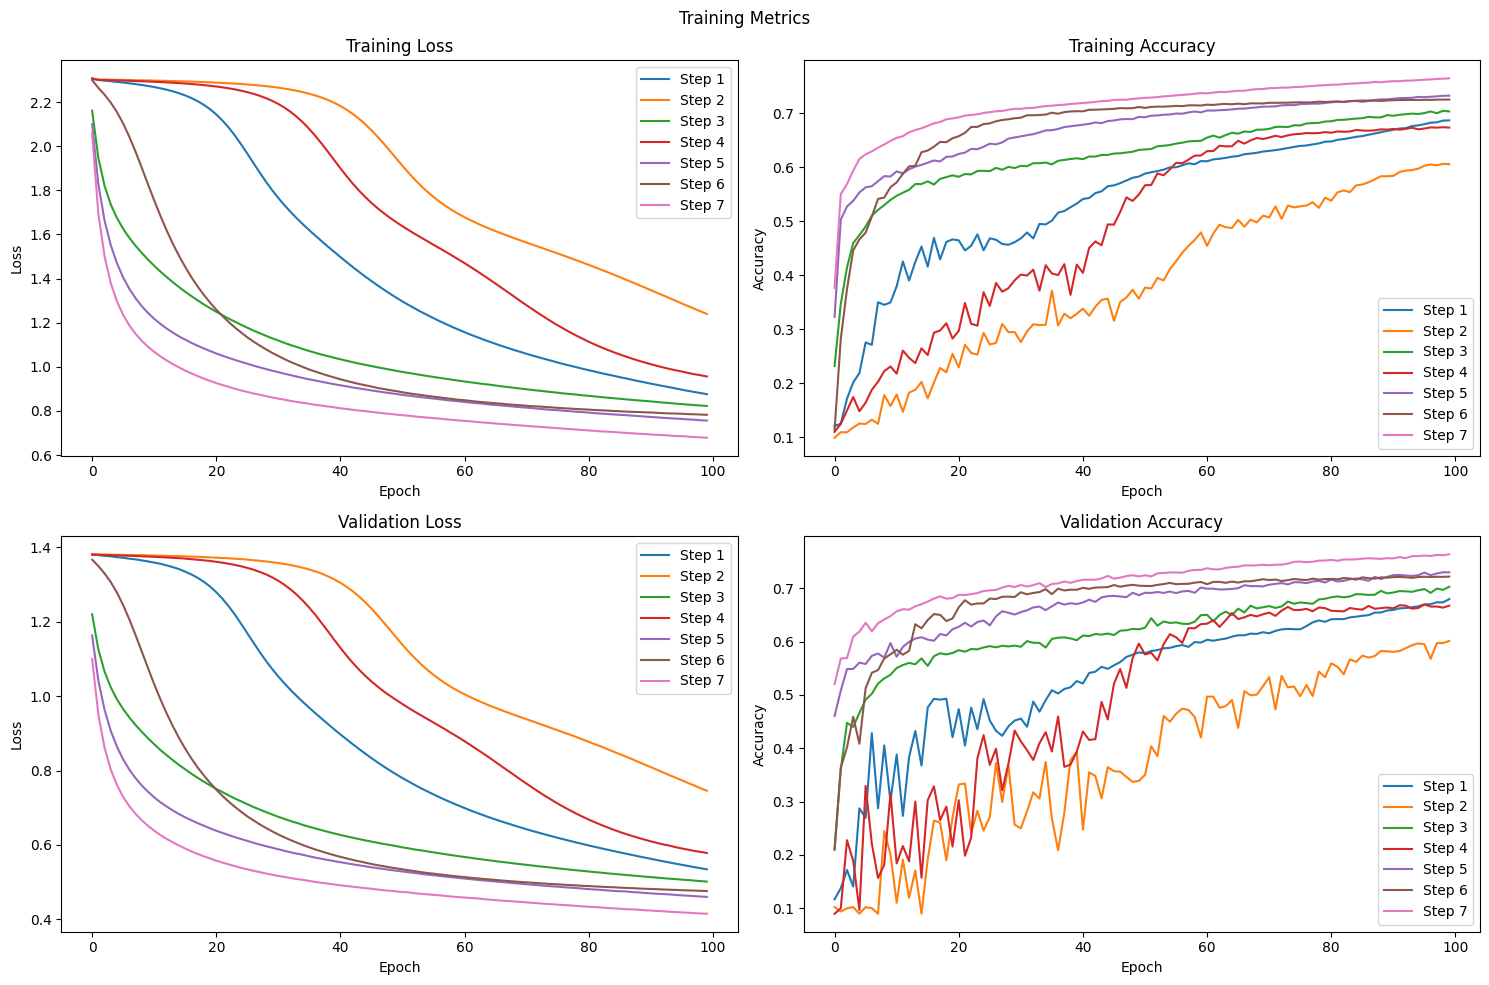

In [10]:
plot_metrics([metrics_1, metrics_2, metrics_3, metrics_4, metrics_5, metrics_6, metrics_7],
            ['Layer 1', 'Layer 2', 'Layer 2_updated', 'Layer 3', 'Layer 3_updated', 'Layer 4', 'Fine-tuning'])

## **4. Evaluation**

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    count = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            loss = criterion(outputs, y_test)
            test_loss += loss.item()
            test_acc += (torch.argmax(outputs, 1) == y_test).sum().item()
            count += len(y_test)

    test_loss /= len(test_loader)
    test_acc /= count

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

evaluate_model(model, test_loader)


Test Results:
Test Loss: 0.6993
Test Accuracy: 0.7614
